# upperlimit

In [1]:
#source /export/ciao/bin/ciao.bash -o
PFILES="./param;$ASCDS_INSTALL/param:$ASCDS_INSTALL/contrib/param"
mkdir -p ./param
ASCDS_WORK_PATH=./


In [2]:
/bin/rm -rf 315 
download_chandra_obsid 315 --exclude evt2,vvref,adat,eph1,osol,full_img,cntr_img,oif,aqual,readme
chandra_repro 315 out=`pwd` clob+


  Type     Format      Size  0........H.........1  Download Time Average Rate
  ---------------------------------------------------------------------------
  evt1     fits      213 Mb  ####################            3 s  63593.8 kb/s
  asol     fits       19 Mb  ####################          < 1 s  44431.6 kb/s
  aoff     fits        8 Mb  ####################          < 1 s  30133.4 kb/s
  mtl      fits        3 Mb  ####################          < 1 s  27947.9 kb/s
  stat     fits        2 Mb  ####################          < 1 s  36732.6 kb/s
  bias     fits      500 Kb  ####################          < 1 s  11772.1 kb/s
  bias     fits      448 Kb  ####################          < 1 s  20160.6 kb/s
  bias     fits      441 Kb  ####################          < 1 s  19298.7 kb/s
  bias     fits      441 Kb  ####################          < 1 s  25480.4 kb/s
  bias     fits      440 Kb  ####################          < 1 s  26794.6 kb/s
  src_img  jpg        49 Kb  ####################    

## Display in ds9

[1] 676558
[1]+  Done                    ds9 acisf00315_repro_evt2.fits -pan to 4200 3850 physical -scale log


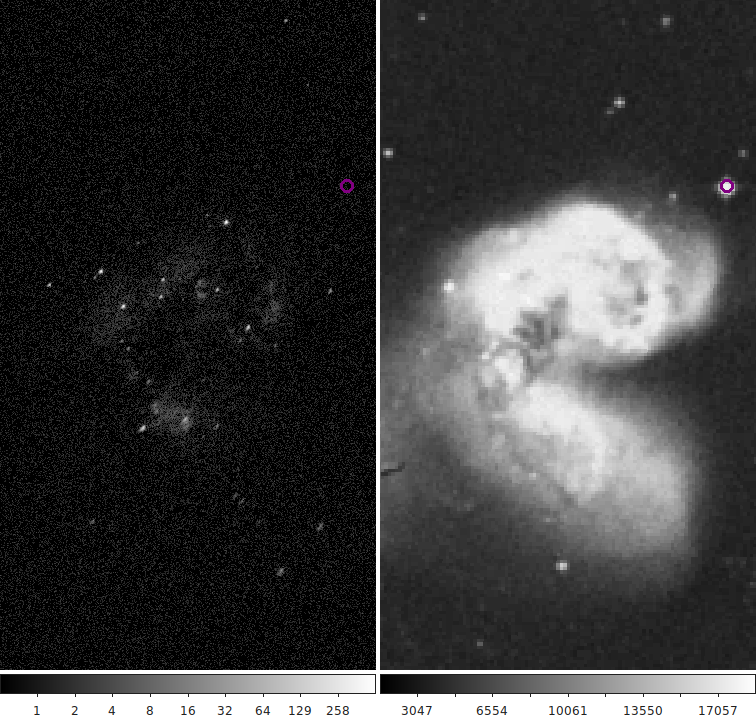

In [3]:
ds9 acisf00315_repro_evt2.fits \
  -pan to 4200 3850 physical \
  -scale log &

sleep 3

xpaset -p ds9 cmap grey
echo "fk5; circle point 12:01:47.9 -18:51:15.6 # color=purple width=3" | xpaset ds9 region -format ds9

xpaset -p ds9 dsssao 
xpaset -p ds9 dsssao close
xpaset -p ds9 scale linear
echo "fk5; circle point 12:01:47.9 -18:51:15.6 # color=purple width=3" | xpaset ds9 region -format ds9
xpaset -p ds9 frame first
xpaset -p ds9 match frame wcs

xpaset -p ds9 saveimage png ds9_01.png
xpaset -p ds9 quit

display < ds9_01.png



## Run srcflux

In [4]:
punlearn srcflux
pset srcflux infile=acisf00315_repro_evt2.fits
pset srcflux outroot=dss
pset srcflux pos="12:01:47.9 -18:51:15.6"
pset srcflux psfmethod=quick
srcflux mode=h clob+

srcflux
          infile = acisf00315_repro_evt2.fits
             pos = 12:01:47.9 -18:51:15.6
         outroot = dss
           bands = default
          srcreg = 
          bkgreg = 
         bkgresp = yes
       psfmethod = quick
         psffile = 
            conf = 0.9
         binsize = 1
         rmffile = 
         arffile = 
           model = xspowerlaw.pow1
       paramvals = pow1.PhoIndex=2.0
        absmodel = xsphabs.abs1
       absparams = abs1.nH=%GAL%
           abund = angr
      pluginfile = 
         fovfile = 
        asolfile = 
         mskfile = 
        bpixfile = 
         dtffile = 
         ecffile = CALDB
        parallel = yes
           nproc = INDEF
          tmpdir = ./
     random_seed = -1
         clobber = yes
         verbose = 1
            mode = h

Processing OBI 001
Extracting counts
Getting net rate and confidence limits
Getting model independent fluxes 
Getting model fluxes 
Getting photon fluxes 
Getting variability
Running tasks in parall

In [5]:
dmlist "dss_broad.flux[cols counts,bg_counts,area,bg_area,net_rate_aper_hi]"  data,clean

#  COUNTS               BG_COUNTS            AREA                 BG_AREA              NET_RATE_APER_HI
                  1.0                 21.0               20.750             476.3750          5.28827E-05


In [27]:
dmlist "dss_broad.flux[cols net_photflux_aper,net_photflux_aper_lo,net_photflux_aper_hi]" data,clean

#  NET_PHOTFLUX_APER    NET_PHOTFLUX_APER_LO NET_PHOTFLUX_APER_HI
      3.752809674E-09                    0      1.524576588E-07


## Step-by-Step

### 1. Select Apertures

In [6]:
cat << EOM > src.reg
circle(12:01:47.9,-18:51:15.6,5")
EOM

In [7]:
cat << EOM > bkg.reg
annulus(12:01:47.9,-18:51:15.6,5",15")
EOM

In [8]:
# ds9 acisf00315_repro_evt2.fits \
#   -region load src.reg \
#   -region background \
#   -region load bkg.reg

### 2. Counts in src and bkg regions

In [9]:
n=`dmlist 'acisf00315_repro_evt2.fits[energy=500:7000][sky=region(src.reg)]' counts`
echo $n

15


In [10]:
m=`dmlist 'acisf00315_repro_evt2.fits[energy=500:7000][sky=region(bkg.reg)]' counts`
echo $m

132


### 3. Area

In [11]:
A_s=`echo '5*5*3.141592' | bc -l`
echo $A_s

78.539800


In [12]:
A_b=`echo '(15*15-5*5)*3.141592' | bc -l`
echo $A_b

628.318400


### 4. Exposure Time

In [13]:
T=` dmkeypar acisf00315_repro_evt2.fits LIVETIME echo+`
echo $T

72242.199605928


In [14]:
dmstat dss_0001_broad_thresh.expmap"[sky=region(src.reg)]" cen- sig- med- 
E_s=`pget dmstat out_mean`
echo $E_s

EXPMAP[cm**2 s]
    min:	25943108 	      @:	( 4353 4007 )
    max:	26088824 	      @:	( 4364 3990 )
   mean:	26021691.451 
    sum:	8535114796 
   good:	328 
   null:	113 
26021691.451


In [15]:
dmstat dss_0001_broad_thresh.expmap"[sky=region(bkg.reg)]" cen- sig- med- 
E_b=`pget dmstat out_mean`
echo $E_b

EXPMAP[cm**2 s]
    min:	25867038 	      @:	( 4352 4013 )
    max:	26158504 	      @:	( 4373 3985 )
   mean:	26014718.441 
    sum:	13345550560 
   good:	513 
   null:	328 
26014718.441


### 5. Run aprates

In [16]:
punlearn aprates
pset aprates n=$n m=$m
pset aprates A_s=$A_s A_b=$A_b
pset aprates T_s=$T T_b=$T
pset aprates alpha=1.0 beta=0.0
pset aprates conf=0.68
pset aprates outfile=ulimit.par
pset aprates E_s=$E_s E_b=$E_b
aprates mode=h clob+

In [17]:
pget ulimit.par src_rate src_rate_err_lo src_rate_err_up

0
INDEF
5.775e-05


In [18]:
pget ulimit.par photflux_aper photflux_aper_err_lo photflux_aper_err_up

0
INDEF
1.58745e-07


In [28]:
cat ulimit.par


src_cnts,r,h,0.0,,,
src_cnts_err_lo,r,h,INDEF,,,
src_cnts_err_up,r,h,4.17198,,,
src_cnts_conf,r,h,0.684242,,,
src_cnts_status,i,h,0,,,
src_cnts_signif,r,h,0,,,
src_cnts_mode,r,h,0,,,
src_rate,r,h,0.0,,,
src_rate_err_lo,r,h,INDEF,,,
src_rate_err_up,r,h,5.775e-05,,,
src_rate_conf,r,h,0.684242,,,
src_rate_status,i,h,0,,,
src_rate_signif,r,h,0,,,
src_rate_mode,r,h,0,,,
photflux_aper,r,h,0.0,,,
photflux_aper_err_lo,r,h,INDEF,,,
photflux_aper_err_up,r,h,1.58745e-07,,,
photflux_aper_conf,r,h,0.680054,,,
photflux_aper_status,i,h,0,,,
photflux_aper_signif,r,h,0,,,
photflux_aper_mode,r,h,0,,,
flux_aper,r,h,0.0,,,
flux_aper_err_lo,r,h,0,,,
flux_aper_err_up,r,h,0,,,
flux_aper_conf,r,h,0,,,
flux_aper_status,i,h,4,,,
flux_aper_signif,r,h,0,,,
flux_aper_mode,r,h,0,,,
eflux_aper,r,h,0.0,,,
eflux_aper_err_lo,r,h,0,,,
eflux_aper_err_up,r,h,0,,,
eflux_aper_conf,r,h,0,,,
eflux_aper_status,i,h,4,,,
eflux_aper_signif,r,h,0,,,
eflux_aper_mode,r,h,0,,,
# ---- Inputs below ----
_n,i,h,15,,,
_A_s,r,h,78.5398,,,

### 6. run aplimits

In [19]:
punlearn aplimits
pset aplimits m=$m bkg_rate=INDEF
pset aplimits A_s=$A_s A_b=$A_b
pset aplimits T_s=$T T_b=$T
#pset aplimits alpha=1.0 beta=0.0
#pset aplimits conf=0.68
pset aplimits outfile=ulimit_2.par
aplimits mode=h prob_missed_detect=0.50 clob+

aplimits
prob_false_detection = 0.1
prob_missed_detection = 0.5
         outfile = ulimit_2.par
             T_s = 72242.19960592801
             A_s = 78.5398
        bkg_rate = INDEF
               m = 132
             T_b = 72242.19960592801
             A_b = 628.3184
      max_counts = 50
          maxfev = 500
         verbose = 1
         clobber = yes
            mode = h

Minimum number of counts for detection: 22 counts
Upper limit: 8.537294343113899e-05


In [30]:
plist ulimit_2.par


Parameters for ulimit_2.par

(min_counts_detect = 22)              Detection threshold
  (upper_limit = 8.537294343113899e-05) Upper limit
         (mode = ql)              



In [34]:

ls *arf *rmf *pi


dss_0001.arf  dss_0001.rmf     dss_0001_grp.pi
dss_0001.pi   dss_0001_bkg.pi  dss_0001_nopsf.arf


In [40]:
dmlist dss_0001.pi keys,clean | grep -i NH

NRAO_NH                  0.03940 [10**22 cm**-2]    galactic HI column density
BELL_NH                  0.03850 [10**22 cm**-2]    galactic HI column density


In [42]:
punlearn modelflux
pset modelflux arf=dss_0001.arf rmf=dss_0001.rmf 
pset modelflux model="xsphabs.abs1" absmodel="xspowerlaw.pow1"
pset modelflux paramvals="pow1.PhoIndex=2.0" absparams="abs1.nH=0.0394"
modelflux emin=0.5 emax=7.0 rate=8.537e-5 mode=h

Model fluxes:
Rate (0.5,7)= 8.537e-05 count s^-1
Photon Flux (0.5,7)= 1.9862e-07 photon cm^-2 s^-1
Energy Flux (0.5,7)= 4.8176e-16 erg cm^-2 s^-1
Unabsorbed model fluxes:
Rate (0.5,7)= 0.024192 count s^-1
Photon Flux (0.5,7)= 7.7254e-05 photon cm^-2 s^-1
Energy Flux (0.5,7)= 4.7141e-13 erg cm^-2 s^-1


In [44]:
pdump modelflux

arf='dss_0001.arf'
rmf='dss_0001.rmf'
model='xsphabs.abs1'
paramvals='pow1.PhoIndex=2.0'
emin='0.5'
emax='7'
absmodel='xspowerlaw.pow1'
absparams='abs1.nH=0.0394'
abund='angr'
oemin='INDEF'
oemax='INDEF'
rate='8.537e-05'
pflux='1.9862e-07'
flux='4.8176e-16'
urate='0.024192'
upflux='7.7254e-05'
uflux='4.7141e-13'
opt='rate'
verbose='1'
mode='ql'
# EOF


# Cleanup


In [21]:
/bin/rm -rf 315 
/bin/rm -f acisf* pcadf* 